# Hybrid model for pneumonia detection
## 1. Setup
### 1.1. Installing dependencies

In [8]:
!pip install pennylane scikit-learn numpy scipy matplotlib pandas pennylane-qiskit kagglehub scikit-image seaborn opencv-python torch torchvision pennylane-lightning-gpu optuna

In [9]:
from dataclasses import dataclass
import torch
import numpy as np
import random
import os
import math

@dataclass
class ExperimentConfig:
    # Experiment Metadata
    project_name: str = "Hybrid_ResNet50_QNN_Pneumonia"
    seed: int = 6
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Data Paths
    data_root: str = "/home/mforgo/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/"
    output_dir: str = "./results"
    
    # Classical Backbone
    backbone_name: str = "resnet50"  # Fixed naming consistencyd
    feature_dim: int = 2048          # 2048 for ResNet50

    # Preprocessing
    reduction_method: str = "pca"    # 'pca', 'lda' or 'selectkbest'
    target_dims: int = 64             # Dimensionality after reduction
    
    # Quantum Components
    n_qubits: int = math.ceil(math.log2(target_dims))                # Determined by PCA components
    n_layers: int = 6
    encoding_method: str = "amplitude" # 'amplitude' or 'angle'
    
    # Training Hyperparams
    batch_size: int = 16
    learning_rate: float = 0.001
    epochs: int = 50
    patience: int = 10
    min_learning_rate: float = 1e-5
    warmup_epochs: int = 3

    

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🔒 Global seed set to {seed}")

CFG = ExperimentConfig()
seed_everything(CFG.seed)
os.makedirs(CFG.output_dir, exist_ok=True)


🔒 Global seed set to 6


In [10]:
import kagglehub

# Download latest version
CFG.data_root = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia") + "/chest_xray/"
print("Path to dataset files:", CFG.data_root)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia/chest_xray/


## 2. Hybrid model
### 2.1. Classical preprocessing

In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os

def get_transforms(img_size=224):
    """
    Standard ImageNet normalization. 
    Using standard stats ensures the pre-trained ResNet works as intended.
    """
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_dataloaders(config):
    """
    Creates DataLoaders for Train/Test/Val using ImageFolder.
    This replaces manual os.listdir loops.
    """
    loaders = {}
    sets = ['train', 'test', 'val']
    
    print(f"📂 Loading data from: {config.data_root}")
    
    for split in sets:
        path = os.path.join(config.data_root, split)
        if not os.path.exists(path):
            print(f"⚠️ Warning: Split '{split}' not found at {path}")
            continue
            
        # ImageFolder automatically handles class labels based on folder names
        dataset = datasets.ImageFolder(root=path, transform=get_transforms())
        
        loaders[split] = DataLoader(
            dataset, 
            batch_size=config.batch_size, 
            shuffle=False, # Important: Keep False to match features with filenames later
            num_workers=2, # Parallel loading
            pin_memory=True
        )
        print(f"   • {split.upper()}: Found {len(dataset)} images")
        
    return loaders

class FeatureExtractor(nn.Module):
    """
    Wraps ResNet50 to output raw features instead of classification scores.
    """
    def __init__(self):
        super().__init__()
        # Load modern V2 weights for better performance
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        self.backbone = models.resnet50(weights=weights)
        
        # Replace the final classification layer (fc) with Identity
        # This allows us to get the 2048 feature vector directly
        self.backbone.fc = nn.Identity()
        self.backbone.eval() # Set to evaluation mode (freezes BatchNorm)
        
    def forward(self, x):
        return self.backbone(x)

def run_feature_extraction(config):
    """
    The Engine: Loads data, passes it through ResNet, and saves features.
    """
    device = torch.device(config.device)
    model = FeatureExtractor().to(device)
    loaders = get_dataloaders(config)
    
    # Create directory for saved features
    save_dir = os.path.join(config.output_dir, "features")
    os.makedirs(save_dir, exist_ok=True)
    
    metadata = []
    
    print(f"\n🚀 Starting extraction with {config.backbone_name} on {device}...")
    
    with torch.no_grad(): # Disable gradient calculation for speed
        for split, loader in loaders.items():
            
            for batch_idx, (images, labels) in enumerate(tqdm(loader, desc=f"Extracting {split}")):
                images = images.to(device)
                
                # Forward pass: Get features (Batch_Size, 2048)
                with torch.amp.autocast(config.device):  # Mixed precision for speed
                    features = model(images)
                
                features = model(images).cpu().numpy()
                # Match features back to original filenames
                # We calculate the global index based on batch size
                start_idx = batch_idx * config.batch_size
                
                for i, feat in enumerate(features):
                    global_idx = start_idx + i
                    # Retrieve path from dataset.samples which is [(path, class_idx), ...]
                    original_path, label_idx = loader.dataset.samples[global_idx]
                    filename = os.path.basename(original_path)
                    classname = loader.dataset.classes[label_idx]
                    
                    # Save individual feature file
                    save_name = f"{split}_{classname}_{filename}.npy"
                    save_path = os.path.join(save_dir, save_name)
                    np.save(save_path, feat)
                    
                    metadata.append({
                        'feature_path': save_path,
                        'label': label_idx, # 0 or 1
                        'classname': classname,
                        'split': split,
                        'original_path': original_path
                    })
    
    # Save metadata CSV for easy loading later
    meta_path = os.path.join(config.output_dir, "metadata.csv")
    pd.DataFrame(metadata).to_csv(meta_path, index=False)
    print(f"✅ Extraction complete. Metadata saved to {meta_path}")
    return meta_path

# Execute the pipeline using our Config
meta_csv_path = run_feature_extraction(CFG)

📂 Loading data from: /kaggle/input/chest-xray-pneumonia/chest_xray/
   • TRAIN: Found 5216 images
   • TEST: Found 624 images
   • VAL: Found 16 images

🚀 Starting extraction with resnet50 on cuda...


Extracting train:   0%|          | 0/326 [00:00<?, ?it/s]

Extracting test:   0%|          | 0/39 [00:00<?, ?it/s]

Extracting val:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Extraction complete. Metadata saved to ./results/metadata.csv


In [12]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split  
import joblib
import os

def load_features(config):
    """
    Loads features from .npy files based on the metadata CSV.
    """
    meta_path = os.path.join(config.output_dir, "metadata.csv")
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"Metadata CSV not found at {meta_path}. Run Step 3 first.")
    
    df = pd.read_csv(meta_path)
    splits = ['train', 'val', 'test']
    
    X, y = {}, {}
    
    print(f"📂 Loading raw features...")
    for split in splits:
        subset = df[df['split'] == split]
        features = [np.load(path) for path in subset['feature_path']]
        X[split] = np.vstack(features)
        y[split] = subset['label'].values
    
    return X, y

def fix_validation_split(X, y, config):
    """
    OPRAVA: Sloučí Train (5216) a Val (16) a vytvoří nové rozdělení 80/20.
    Tím získáme cca 1000 validačních snímků místo 16.
    """
    print("\n⚠️ Fixing small validation set issue...")
    
    # 1. Sloučení
    X_combined = np.concatenate([X['train'], X['val']])
    y_combined = np.concatenate([y['train'], y['val']])
    
    # 2. Nové rozdělení (stratify zajistí správný poměr tříd)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
        X_combined, y_combined, 
        test_size=0.2, 
        stratify=y_combined, 
        random_state=config.seed
    )
    
    # 3. Aktualizace slovníků
    X['train'], y['train'] = X_train_new, y_train_new
    X['val'], y['val']     = X_val_new, y_val_new
    
    print(f"   Original Val size: 16 -> New Val size: {len(X_val_new)}")
    print(f"   New Train size:    {len(X_train_new)}")

    # Class balance check
    for split in ['train', 'val', 'test']:
        pneumonia_pct = np.mean(y[split] == 1) * 100
        print(f"{split}: {pneumonia_pct:.1f}% pneumonia")

    return X, y

def build_pipeline(config):
    steps = [('scaler', StandardScaler())]
    
    if config.reduction_method == 'pca':
        steps.append(('reducer', PCA(n_components=config.target_dims, random_state=config.seed)))
    elif config.reduction_method == 'selectkbest':
        steps.append(('reducer', SelectKBest(score_func=f_classif, k=config.target_dims)))
    elif config.reduction_method == 'lda':
        steps.append(('reducer', LDA(n_components=min(config.target_dims, 1))))
    
    if config.encoding_method == 'amplitude':
        steps.append(('normalizer', Normalizer(norm='l2')))
    elif config.encoding_method == 'angle':
        steps.append(('minmax', MinMaxScaler(feature_range=(0, np.pi))))
        
    return Pipeline(steps)

def run_classical_preprocessing(config):
    # 1. Load Data
    X, y = load_features(config)
    
    # 2. FIX DATA SPLIT (Tohle je ta klíčová oprava)
    X, y = fix_validation_split(X, y, config)
    
    # 3. Build & Fit Pipeline
    pipeline = build_pipeline(config)
    print(f"\n🔄 Fitting {config.reduction_method.upper()} Pipeline...")
    
    pipeline.fit(X['train'], y['train'])
    
    # 4. Transform & Save
    X_processed = {
        'train': pipeline.transform(X['train']),
        'val':   pipeline.transform(X['val']),
        'test':  pipeline.transform(X['test'])
    }
    
    processed_dir = os.path.join(config.output_dir, "processed_data")
    os.makedirs(processed_dir, exist_ok=True)
    
    for split in ['train', 'val', 'test']:
        np.save(os.path.join(processed_dir, f"X_{split}.npy"), X_processed[split])
        np.save(os.path.join(processed_dir, f"y_{split}.npy"), y[split])
        
    pipeline_path = os.path.join(config.output_dir, "preprocessing_pipeline.joblib")
    joblib.dump(pipeline, pipeline_path)
    
    print(f"✅ Preprocessing complete. Data ready for Quantum Training.")
    return X_processed, y

# Spuštění opraveného kroku
X_data, y_data = run_classical_preprocessing(CFG)

📂 Loading raw features...

⚠️ Fixing small validation set issue...
   Original Val size: 16 -> New Val size: 1047
   New Train size:    4185
train: 74.2% pneumonia
val: 74.2% pneumonia
test: 62.5% pneumonia

🔄 Fitting PCA Pipeline...
✅ Preprocessing complete. Data ready for Quantum Training.


In [13]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
from tqdm.notebook import tqdm
import os
import json
import time
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import math

class CosineAnnealingScheduler:
    """Smooth cosine annealing schedule instead of manual steps."""
    def __init__(self, initial_lr=0.002, min_lr=0.0001, epochs=50, warmup_epochs=2):
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.epochs = epochs
        self.warmup_epochs = warmup_epochs

    def get_lr(self, epoch):
        """Compute learning rate for given epoch."""
        if epoch < self.warmup_epochs:
            return self.initial_lr * (epoch + 1) / self.warmup_epochs
        progress = (epoch - self.warmup_epochs) / (self.epochs - self.warmup_epochs)
        return self.min_lr + (self.initial_lr - self.min_lr) * (1 + math.cos(math.pi * progress)) / 2

    def step(self, optimizer, epoch):
        """Update optimizer's learning rate."""
        lr = self.get_lr(epoch)
        optimizer.stepsize = lr
        return lr

# --- 1. Modular Quantum Layers ---

def get_device(config):
    """Creates a PennyLane device with GPU acceleration."""
    try:
        # This uses NVIDIA cuQuantum for massive speedups on A100/L4
        return qml.device("lightning.gpu", wires=config.n_qubits)
    except:
        # Fallback if GPU is not available
        return qml.device("default.qubit", wires=config.n_qubits)

def embedding_layer(features, config):
    """
    Encodes a BATCH of classical data into quantum states.
    """
    wires = range(config.n_qubits)
    
    if config.encoding_method == 'amplitude':
        # PennyLane will detect if features has a batch dimension (e.g., shape 32, 64)
        qml.AmplitudeEmbedding(features=features, wires=wires, normalize=True, pad_with=0.0)
        
    elif config.encoding_method == 'angle':
        qml.AngleEmbedding(features=features, wires=wires, rotation='Y')

def ansatz_layer(params, config):
    """
    Optimized Ansatz for batched inputs.
    """
    n_wires = config.n_qubits
    
    for l in range(config.n_layers):
        # Parameterized Rotations
        for w in range(n_wires):
            # Rot is compatible with batching when using broadcastable params
            qml.Rot(params[l, w, 0], params[l, w, 1], params[l, w, 2], wires=w)
            
        # Entangling Layer
        for w in range(n_wires):
            qml.CNOT(wires=[w, (w + 1) % n_wires])

# --- 2. The QNode Builder ---

def build_qnode(config):
    dev = get_device(config)
    
    @qml.qnode(dev, interface="autograd", diff_method="adjoint", cache=True)
    def qnode(inputs, params):
        embedding_layer(inputs, config)
        #qml.StronglyEntanglingLayers(params, wires=range(config.n_qubits))
        ansatz_layer(params, config)
        # When inputs is batched, this returns a batch of expectation values
        return qml.expval(qml.PauliZ(0))
        
    return qnode 

# --- 3. Training Engine ---

def train_quantum_model(config, X_data, y_data):
    """
    Main training loop using Autograd.
    """
    print(f"\n⚛️ Initializing Quantum Model ({config.n_qubits} Qubits, {config.n_layers} Layers)...")
    
    # Initialize QNode
    qnode = build_qnode(config)
    
    # Initialize Parameters (Random weights)
    # Shape matching our manual ansatz: (L, N_wires, 3)
    param_shape = (config.n_layers, config.n_qubits, 3)
    params = pnp.random.uniform(0, 2*np.pi, size=param_shape, requires_grad=True)
    
    # Optimizer
    opt = qml.AdamOptimizer(stepsize=config.learning_rate)

    scheduler = CosineAnnealingScheduler(
        initial_lr=config.learning_rate, 
        min_lr=config.min_learning_rate, 
        epochs=config.epochs,
        warmup_epochs=config.warmup_epochs
    )

    # Cost Function (MSE)
    def cost_fn(params, x_batch, y_batch):
        # 1. Get Predictions
        # If your QNode isn't configured for batching yet, use the list comprehension method:
        # preds = pnp.stack([qnode(x, params) for x in x_batch]) 
        preds = qnode(x_batch, params)
        
        # 2. Prepare Targets
        # Map: Normal (0) -> -1, Pneumonia (1) -> 1
        targets = pnp.array([1 if y == 1 else -1 for y in y_batch], requires_grad=False)
        
        # 3. Define Weights (The Fix)
        # We punish errors on 'Normal' cases more heavily to balance the data
        w_normal = len(y_train) / (2 * np.sum(y_train == 0))    # High penalty for missing a normal case
        w_pneumonia = len(y_train) / (2 * np.sum(y_train == 1)) # Standard penalty
        
        # Create a weight vector matching the current batch
        batch_weights = pnp.array(
            [w_normal if t == -1 else w_pneumonia for t in targets], 
            requires_grad=False
        )
        
        # 4. Calculate Weighted MSE
        # Formula: weight * (prediction - target)^2
        squared_errors = (preds - targets) ** 2
        weighted_loss = batch_weights * squared_errors
        
        return pnp.mean(weighted_loss)

    # Tracking
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_params = None
    
    # Data Setup
    X_train, y_train = X_data['train'], y_data['train']
    X_val, y_val = X_data['val'], y_data['val']
    
    batch_size = config.batch_size
    n_batches = len(X_train) // batch_size
    
    print(f"🚀 Starting training for {config.epochs} epochs...")
    
    start_time = time.time()
    
    for epoch in range(config.epochs):
        # Update Learning Rate
        lr = scheduler.step(opt, epoch)

        # Shuffle
        perm = np.random.permutation(len(X_train))
        X_train = X_train[perm]
        y_train = y_train[perm]
        
        epoch_loss = 0
        
        # Batch Loop
        with tqdm(total=n_batches, desc=f"Epoch {epoch+1}/{config.epochs}", leave=False) as pbar:
            for i in range(n_batches):
                batch_idx = slice(i * batch_size, (i + 1) * batch_size)
                X_batch = X_train[batch_idx]
                y_batch = y_train[batch_idx]
                
                # Step
                params, loss = opt.step_and_cost(lambda p: cost_fn(p, X_batch, y_batch), params)
                epoch_loss += loss
                pbar.update(1)
                pbar.set_postfix({'loss': f"{loss:.4f}"})
        
        avg_train_loss = epoch_loss / n_batches
        
        # Validation
        val_loss = cost_fn(params, X_val, y_val)
        
        # Val Accuracy (threshold at 0.0 because PauliZ is [-1, 1])
        # Faster Validation in the training loop
        val_preds_raw = qnode(X_val, params) # Pass all validation data at once if memory allows
        val_preds = (val_preds_raw > 0).astype(int) 
        val_acc = accuracy_score(y_val, val_preds)
        
        history['train_loss'].append(float(avg_train_loss))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(val_acc)
        
        print(f"   Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f} | LR {lr:.6f}")
        
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params.copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= config.patience:
            print(f"⏹ Early stopping at epoch {epoch+1}")
            break
            
    train_time = time.time() - start_time
    print(f"✅ Training done in {train_time:.1f}s. Best Val Loss: {best_val_loss:.4f}")
    
    return best_params, qnode, history

# --- 4. Evaluation Function ---

def evaluate_model(config, params, qnode, X_test, y_test):
    print("\n📊 Evaluating on Test Set...")
    preds_raw = np.array([qnode(x, params) for x in X_test])
    
    # Map [-1, 1] -> [0, 1]
    probs = (preds_raw + 1) / 2
    preds = (probs > 0.5).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_test, preds),
        'f1_score': f1_score(y_test, preds, average='macro'),
        'auc_score': roc_auc_score(y_test, probs)
    }
    
    print(f"   Test Accuracy: {metrics['accuracy']:.2%}")
    print(f"   Test F1 Score: {metrics['f1_score']:.4f}")
    print(f"   Test AUC:      {metrics['auc_score']:.4f}")
    return metrics, preds, probs

# --- Execution ---
# 1. Train
best_params, qnode, history = train_quantum_model(CFG, X_data, y_data)

# 2. Evaluate
test_metrics, test_preds, test_probs = evaluate_model(CFG, best_params, qnode, X_data['test'], y_data['test'])

# 3. Save
results_path = os.path.join(CFG.output_dir, "quantum_results.json")
with open(results_path, 'w') as f:
    json.dump({
        'config': {k: str(v) for k, v in CFG.__dict__.items()},
        'metrics': test_metrics,
        'history': history
    }, f, indent=4)
np.save(os.path.join(CFG.output_dir, "best_params.npy"), best_params)
print(f"💾 Saved to {results_path}")


⚛️ Initializing Quantum Model (6 Qubits, 6 Layers)...
🚀 Starting training for 50 epochs...


Epoch 1/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 1: Train Loss 0.9898 | Val Loss 0.9609 | Val Acc 0.5654 | LR 0.000333


Epoch 2/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 2: Train Loss 0.9127 | Val Loss 0.8680 | Val Acc 0.6638 | LR 0.000667


Epoch 3/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 3: Train Loss 0.8305 | Val Loss 0.7960 | Val Acc 0.7182 | LR 0.001000


Epoch 4/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 4: Train Loss 0.7788 | Val Loss 0.7627 | Val Acc 0.7641 | LR 0.001000


Epoch 5/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 5: Train Loss 0.7539 | Val Loss 0.7453 | Val Acc 0.7736 | LR 0.000999


Epoch 6/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 6: Train Loss 0.7426 | Val Loss 0.7356 | Val Acc 0.7784 | LR 0.000996


Epoch 7/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 7: Train Loss 0.7361 | Val Loss 0.7291 | Val Acc 0.7870 | LR 0.000990


Epoch 8/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 8: Train Loss 0.7318 | Val Loss 0.7236 | Val Acc 0.7956 | LR 0.000982


Epoch 9/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 9: Train Loss 0.7274 | Val Loss 0.7184 | Val Acc 0.8023 | LR 0.000973


Epoch 10/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 10: Train Loss 0.7247 | Val Loss 0.7139 | Val Acc 0.8061 | LR 0.000961


Epoch 11/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 11: Train Loss 0.7208 | Val Loss 0.7098 | Val Acc 0.8052 | LR 0.000947


Epoch 12/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 12: Train Loss 0.7169 | Val Loss 0.7066 | Val Acc 0.8004 | LR 0.000931


Epoch 13/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 13: Train Loss 0.7135 | Val Loss 0.7029 | Val Acc 0.8071 | LR 0.000913


Epoch 14/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 14: Train Loss 0.7101 | Val Loss 0.6997 | Val Acc 0.8061 | LR 0.000893


Epoch 15/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 15: Train Loss 0.7075 | Val Loss 0.6975 | Val Acc 0.8090 | LR 0.000872


Epoch 16/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 16: Train Loss 0.7049 | Val Loss 0.6950 | Val Acc 0.8099 | LR 0.000849


Epoch 17/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 17: Train Loss 0.7025 | Val Loss 0.6931 | Val Acc 0.8176 | LR 0.000825


Epoch 18/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 18: Train Loss 0.7004 | Val Loss 0.6912 | Val Acc 0.8243 | LR 0.000799


Epoch 19/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 19: Train Loss 0.6990 | Val Loss 0.6895 | Val Acc 0.8271 | LR 0.000771


Epoch 20/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 20: Train Loss 0.6977 | Val Loss 0.6881 | Val Acc 0.8338 | LR 0.000743


Epoch 21/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 21: Train Loss 0.6965 | Val Loss 0.6869 | Val Acc 0.8386 | LR 0.000713


Epoch 22/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 22: Train Loss 0.6955 | Val Loss 0.6857 | Val Acc 0.8376 | LR 0.000683


Epoch 23/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 23: Train Loss 0.6941 | Val Loss 0.6850 | Val Acc 0.8405 | LR 0.000652


Epoch 24/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 24: Train Loss 0.6938 | Val Loss 0.6841 | Val Acc 0.8415 | LR 0.000620


Epoch 25/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 25: Train Loss 0.6927 | Val Loss 0.6836 | Val Acc 0.8424 | LR 0.000587


Epoch 26/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 26: Train Loss 0.6925 | Val Loss 0.6830 | Val Acc 0.8424 | LR 0.000555


Epoch 27/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 27: Train Loss 0.6919 | Val Loss 0.6823 | Val Acc 0.8424 | LR 0.000522


Epoch 28/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 28: Train Loss 0.6911 | Val Loss 0.6821 | Val Acc 0.8415 | LR 0.000488


Epoch 29/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 29: Train Loss 0.6907 | Val Loss 0.6816 | Val Acc 0.8395 | LR 0.000455


Epoch 30/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 30: Train Loss 0.6908 | Val Loss 0.6813 | Val Acc 0.8415 | LR 0.000423


Epoch 31/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 31: Train Loss 0.6901 | Val Loss 0.6810 | Val Acc 0.8434 | LR 0.000390


Epoch 32/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 32: Train Loss 0.6897 | Val Loss 0.6810 | Val Acc 0.8415 | LR 0.000358


Epoch 33/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 33: Train Loss 0.6889 | Val Loss 0.6806 | Val Acc 0.8405 | LR 0.000327


Epoch 34/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 34: Train Loss 0.6890 | Val Loss 0.6803 | Val Acc 0.8415 | LR 0.000297


Epoch 35/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 35: Train Loss 0.6887 | Val Loss 0.6802 | Val Acc 0.8424 | LR 0.000267


Epoch 36/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 36: Train Loss 0.6883 | Val Loss 0.6801 | Val Acc 0.8434 | LR 0.000239


Epoch 37/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 37: Train Loss 0.6885 | Val Loss 0.6800 | Val Acc 0.8453 | LR 0.000211


Epoch 38/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 38: Train Loss 0.6880 | Val Loss 0.6799 | Val Acc 0.8443 | LR 0.000185


Epoch 39/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 39: Train Loss 0.6876 | Val Loss 0.6799 | Val Acc 0.8453 | LR 0.000161


Epoch 40/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 40: Train Loss 0.6878 | Val Loss 0.6798 | Val Acc 0.8462 | LR 0.000138


Epoch 41/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 41: Train Loss 0.6875 | Val Loss 0.6798 | Val Acc 0.8462 | LR 0.000117


Epoch 42/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 42: Train Loss 0.6875 | Val Loss 0.6797 | Val Acc 0.8453 | LR 0.000097


Epoch 43/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 43: Train Loss 0.6876 | Val Loss 0.6797 | Val Acc 0.8453 | LR 0.000079


Epoch 44/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 44: Train Loss 0.6876 | Val Loss 0.6796 | Val Acc 0.8443 | LR 0.000063


Epoch 45/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 45: Train Loss 0.6872 | Val Loss 0.6796 | Val Acc 0.8443 | LR 0.000049


Epoch 46/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 46: Train Loss 0.6873 | Val Loss 0.6796 | Val Acc 0.8443 | LR 0.000037


Epoch 47/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 47: Train Loss 0.6871 | Val Loss 0.6796 | Val Acc 0.8443 | LR 0.000028


Epoch 48/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 48: Train Loss 0.6873 | Val Loss 0.6796 | Val Acc 0.8443 | LR 0.000020


Epoch 49/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 49: Train Loss 0.6874 | Val Loss 0.6796 | Val Acc 0.8443 | LR 0.000014


Epoch 50/50:   0%|          | 0/261 [00:00<?, ?it/s]

   Epoch 50: Train Loss 0.6870 | Val Loss 0.6796 | Val Acc 0.8443 | LR 0.000011
✅ Training done in 8145.4s. Best Val Loss: 0.6796

📊 Evaluating on Test Set...
   Test Accuracy: 71.63%
   Test F1 Score: 0.6915
   Test AUC:      0.7445
💾 Saved to ./results/quantum_results.json


In [16]:
# ==========================================
# ⚖️ POST-PROCESSING: Threshold Optimization
# ==========================================
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the probabilities you already generated
# (Assuming 'test_probs' and 'y_data' are still in memory from the previous cell)
y_test = y_data['test']
probs = test_probs

print(f"{'Threshold':<10} | {'Acc':<8} | {'Sens.':<8} | {'Spec.':<8} | {'Balanced Acc':<12}")
print("-" * 60)

best_threshold = 0.5
best_balanced_acc = 0.0

for t in np.arange(0.5, 0.95, 0.05):
    # Apply threshold
    preds_t = (probs > t).astype(int)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, preds_t).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    acc = accuracy_score(y_test, preds_t)
    bal_acc = (sens + spec) / 2
    
    print(f"{t:.2f}       | {acc:.4f}   | {sens:.4f}   | {spec:.4f}   | {bal_acc:.4f}")
    
    if bal_acc > best_balanced_acc:
        best_balanced_acc = bal_acc
        best_threshold = t

print("-" * 60)
print(f"🏆 Best Threshold found: {best_threshold:.2f}")
print(f"   (Maximizes average of Sensitivity and Specificity)")

Threshold  | Acc      | Sens.    | Spec.    | Balanced Acc
------------------------------------------------------------
0.50       | 0.7163   | 0.8000   | 0.5769   | 0.6885
0.55       | 0.6330   | 0.5692   | 0.7393   | 0.6543
0.60       | 0.5288   | 0.3000   | 0.9103   | 0.6051
0.65       | 0.4247   | 0.0897   | 0.9829   | 0.5363
0.70       | 0.3830   | 0.0128   | 1.0000   | 0.5064
0.75       | 0.3750   | 0.0000   | 1.0000   | 0.5000
0.80       | 0.3750   | 0.0000   | 1.0000   | 0.5000
0.85       | 0.3750   | 0.0000   | 1.0000   | 0.5000
0.90       | 0.3750   | 0.0000   | 1.0000   | 0.5000
------------------------------------------------------------
🏆 Best Threshold found: 0.50
   (Maximizes average of Sensitivity and Specificity)


=== VIZUALIZACE VÝSLEDKŮ PRO SOČ ===
📈 Graf tréninku uložen: ./results/training_history.png


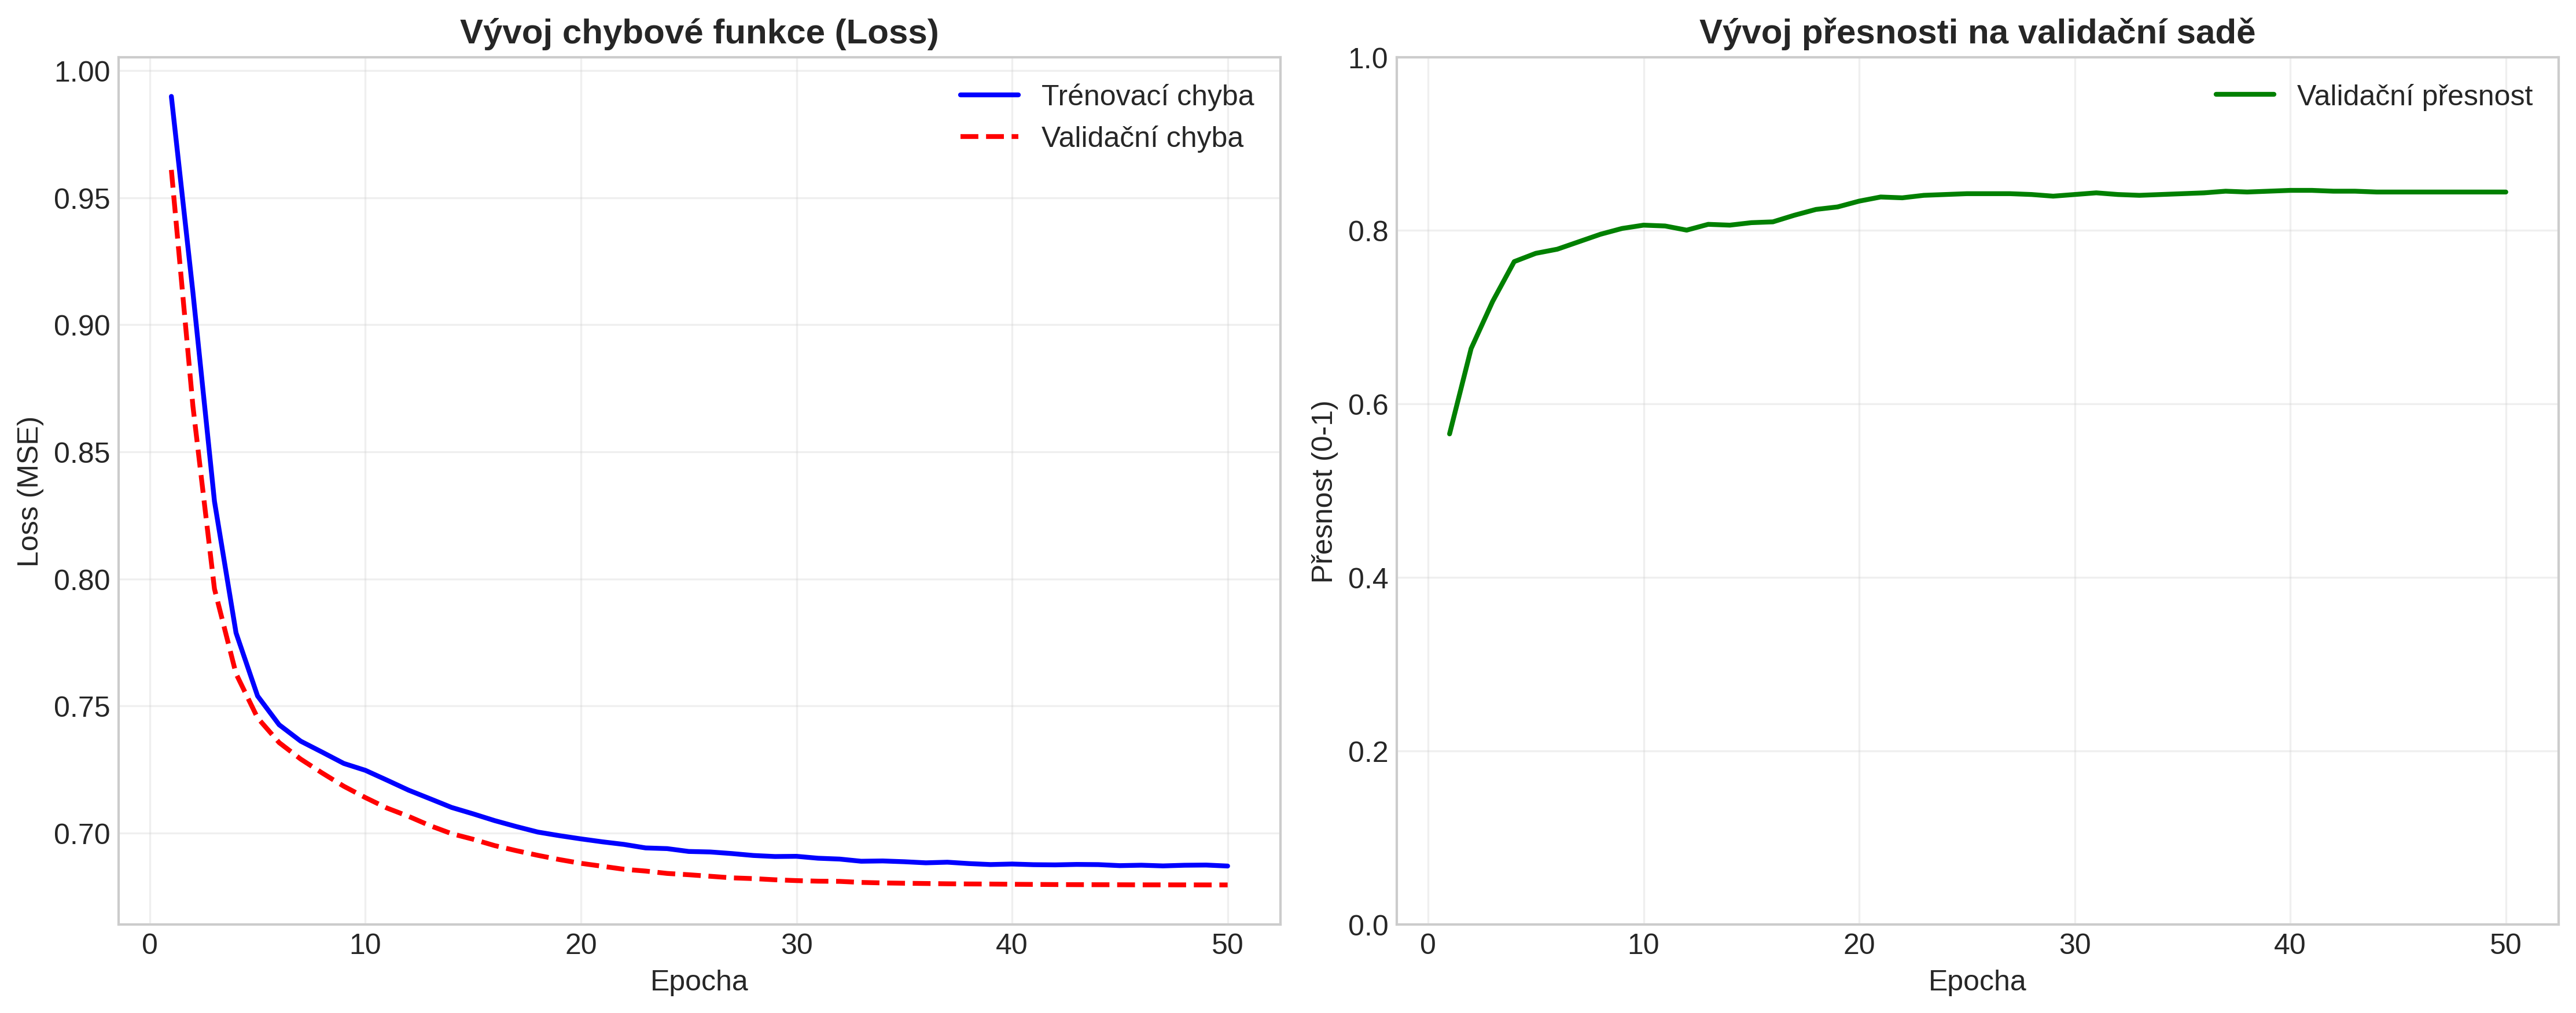

📊 Grafy metrik uloženy: ./results/evaluation_metrics.png


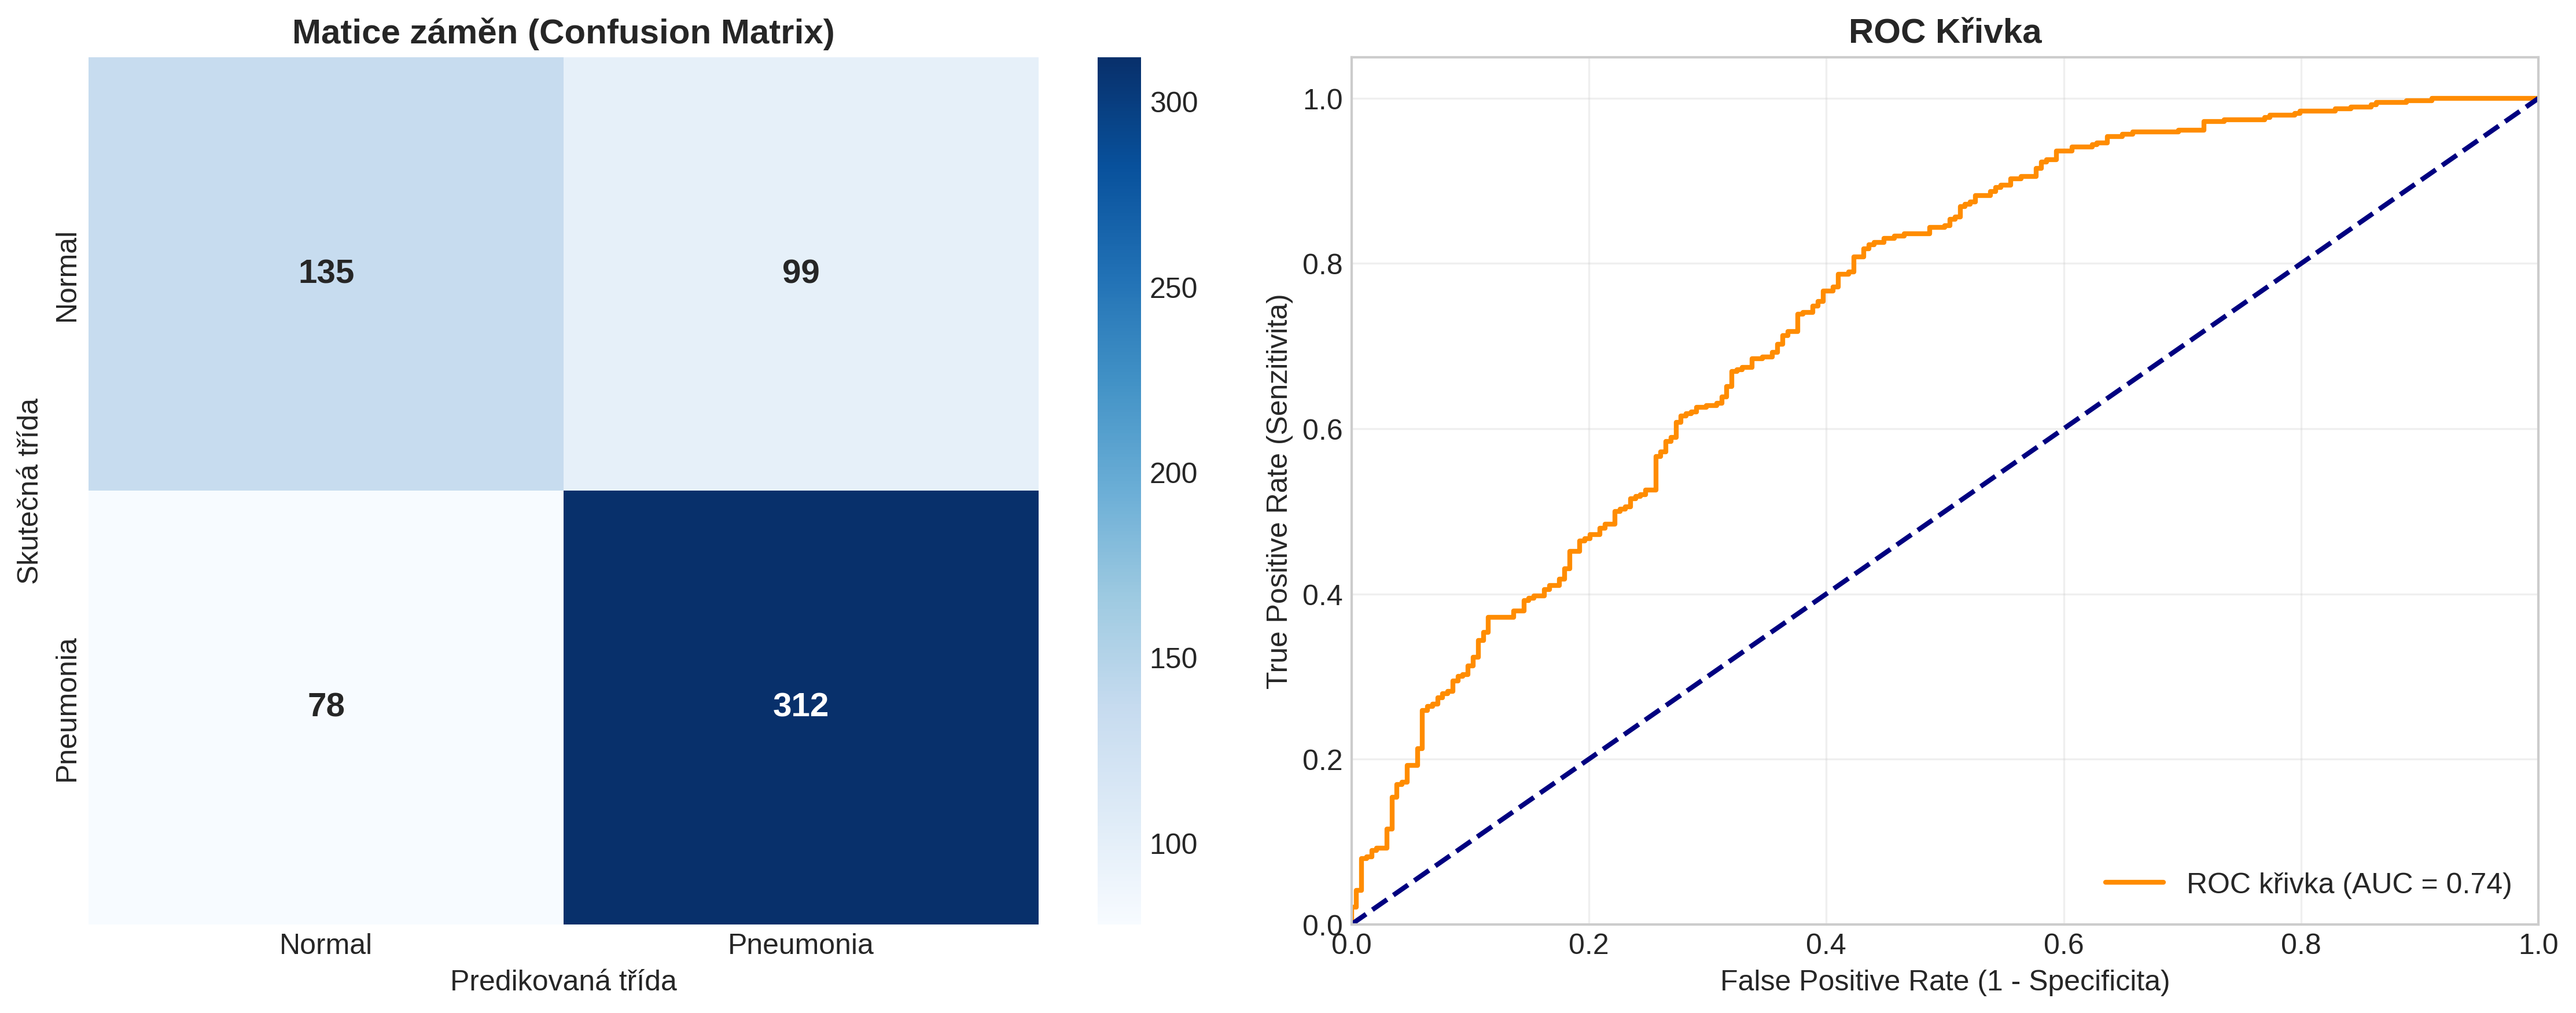


📝 Data pro tabulku výsledků v SOČ:
-----------------------------------
Počet testovacích snímků: 624
TP (Správně Pneumonie):   312
TN (Správně Zdraví):      135
FP (Falešný poplach):     99
FN (Přehlédnutá nemoc):   78
-----------------------------------
Senzitivita (Recall):     0.8000
Specificita:              0.5769
AUC:                      0.7445


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import os

# Nastavení profesionálního vzhledu grafů
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.dpi': 300}) # 300 DPI pro tiskovou kvalitu

def plot_training_history(history, save_dir):
    """
    Vykreslí vývoj chyby (Loss) a přesnosti (Accuracy) během tréninku.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Graf Chyby (Loss)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Trénovací chyba', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r--', label='Validační chyba', linewidth=2)
    ax1.set_title('Vývoj chybové funkce (Loss)', fontweight='bold')
    ax1.set_xlabel('Epocha')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Graf Přesnosti (Accuracy)
    ax2.plot(epochs, history['val_acc'], 'g-', label='Validační přesnost', linewidth=2)
    ax2.set_title('Vývoj přesnosti na validační sadě', fontweight='bold')
    ax2.set_xlabel('Epocha')
    ax2.set_ylabel('Přesnost (0-1)')
    ax2.set_ylim(0, 1.0)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, "training_history.png")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"📈 Graf tréninku uložen: {save_path}")
    plt.show()

def plot_evaluation_metrics(y_true, y_pred, y_probs, save_dir):
    """
    Vykreslí Matici záměn a ROC křivku.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Matice záměn (Confusion Matrix)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'],
                annot_kws={"size": 14, "weight": "bold"})
    ax1.set_title('Matice záměn (Confusion Matrix)', fontweight='bold')
    ax1.set_ylabel('Skutečná třída')
    ax1.set_xlabel('Predikovaná třída')
    
    # 2. ROC Křivka
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC křivka (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate (1 - Specificita)')
    ax2.set_ylabel('True Positive Rate (Senzitivita)')
    ax2.set_title('ROC Křivka', fontweight='bold')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, "evaluation_metrics.png")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"📊 Grafy metrik uloženy: {save_path}")
    plt.show()

# --- Spuštění vizualizace ---

# Používáme proměnné z předchozích kroků:
# history (z kroku 5)
# y_data['test'] (z kroku 4/5 - skutečné hodnoty)
# test_preds (z kroku 5 - predikované 0/1)
# test_probs (z kroku 5 - pravděpodobnosti)

print(f"=== VIZUALIZACE VÝSLEDKŮ PRO SOČ ===")
plot_training_history(history, CFG.output_dir)
plot_evaluation_metrics(y_data['test'], test_preds, test_probs, CFG.output_dir)

# Bonus: Výpis finálních čísel pro text práce
cm = confusion_matrix(y_data['test'], test_preds)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\n📝 Data pro tabulku výsledků v SOČ:")
print(f"-----------------------------------")
print(f"Počet testovacích snímků: {len(y_data['test'])}")
print(f"TP (Správně Pneumonie):   {tp}")
print(f"TN (Správně Zdraví):      {tn}")
print(f"FP (Falešný poplach):     {fp}")
print(f"FN (Přehlédnutá nemoc):   {fn}")
print(f"-----------------------------------")
print(f"Senzitivita (Recall):     {sensitivity:.4f}")
print(f"Specificita:              {specificity:.4f}")
print(f"AUC:                      {roc_auc_score(y_data['test'], test_probs):.4f}")